# Aggregating and Summarizing DAYMET Time Series

It is often useful to utilize daily weather measurements to create your own unique aggregations of data depending on the dependent variable of your model. In this example, we will use Python to develop our own dataset of mean summer precipitation for a region in the Mission Mountains of Montana. This is meant to be used as a loose recipe that can be useful for developing any number of other DAYMET-derived datasets for species distribution modeling.


# Requirements


```
gdal
python 3.6+
numpy
geopandas
matplotlib
```

# Before we get started

This section will run through some basic installations needed for this notebook to run. If you have these installed on your machine already, you can ignore this.

In [ ]:
%%time 
### This whole section is Google Colab specific. Ignore if on other platforms.

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

# Setting up our working directory

This code is designed to execute using relative paths (i.e. from its location in your file system), so we must create subdirectories prior to executing our code. Each `!` means that the following command is a shell command.

In [2]:
# Some working environment setup
!mkdir data
!mkdir data/aoi
!mkdir data/daymet
### Colab-specific to make sure we can access gdal and whatnot
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')

# Developing a DAYMET Query with an AOI

The next step involves creating a query for our data request. In this section we point to a file for our area of interest (AOI), and specify a date range, region, and list of variables. For this example, I am only looking for precipitation data, but we could easily add variables to this list and have them all download during this step.

Let's start out by using Geopandas to look at our area of interest - nothing fancy, we just want to make sure it's looking normal.

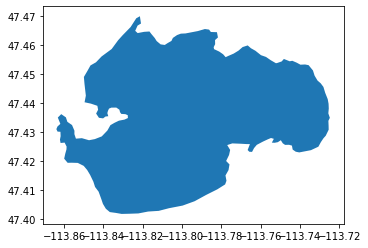

In [4]:
import geopandas as gpd

AOI_f = "/content/data/aoi/mt4743511379720030810_20020710_20040925_burn_bndy.shp"
aoi  = gpd.read_file(AOI_f)
aoi = aoi.to_crs(epsg=4326)

aoi.plot()

Looks good! Now we will build our query and use the `requests` library to make a call to the remote server where DAYMET data are stored. When downloading entire files, you must specify the bounding box of your AOI (in lat/long), date range, and variable of interest.

In [5]:
import gdal
import requests
import getpass
import geopandas as gpd
import requests

START_DATE = "1986-01-01" #Y-m-d format
END_DATE = "2020-01-01"
REGION = "na" #na stands for "north america"
VARIABLES = ["prcp"] #other options are daily minimum and maximum temperature, vapor pressure, shortwave radiation, snow water equivalent, and day length

### Extract variables from constants
startyr = START_DATE[:4]
startmn = START_DATE[5:7]
startday = START_DATE[-2:]
endyr = END_DATE[:4]
endmn = END_DATE[5:7]
endday = END_DATE[-2:]

years = range(int(startyr), int(endyr))

### this gets the bounding box from our shapefile
bounds = aoi.total_bounds

### assign each rounded element of bounding box to variable for convenience
minx = round(bounds[0], 2)
miny = round(bounds[1], 2)
maxx = round(bounds[2], 2)
maxy = round(bounds[3], 2)

### For each variable in our variable list, craft a url that will take us to the correct file, and download it
for var in VARIABLES:
  for year in years:
    url = "https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1840/daymet_v4_daily_{region}_{par}_{i}.nc?var=lat&var=lon&var={par}&north={north}&west={west}&east={east}&south={south}&disableProjSubset=on&horizStride=1&time_start={i}-{startmn}-{startday}T12:00:00Z&time_end={endyr}-{endmn}-{endday}T12:00:00Z&timeStride=1&accept=netcdf".format(region=REGION,
                                                                                  i=year,
                                                                                  endyr=endyr,
                                                                                  par=var,
                                                                                  north=maxy,
                                                                                  south=miny,
                                                                                  west=minx,
                                                                                  east=maxx,
                                                                                  startmn=startmn,
                                                                                  startday=startday,
                                                                                  endmn=endmn,
                                                                                  endday=endday
                                                                                  )
    

    ### Filename for download
    local_filename = "data/daymet/daymet_{}_{}.nc".format(var, year)
    print("Working on {}...".format(url))
    with requests.get(url, stream=True) as r:
      r.raise_for_status()
      with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=100000): 
          f.write(chunk)



Working on https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1840/daymet_v4_daily_na_prcp_1986.nc?var=lat&var=lon&var=prcp&north=47.47&west=-113.86&east=-113.72&south=47.4&disableProjSubset=on&horizStride=1&time_start=1986-01-01T12:00:00Z&time_end=2020-01-01T12:00:00Z&timeStride=1&accept=netcdf...
Working on https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1840/daymet_v4_daily_na_prcp_1987.nc?var=lat&var=lon&var=prcp&north=47.47&west=-113.86&east=-113.72&south=47.4&disableProjSubset=on&horizStride=1&time_start=1987-01-01T12:00:00Z&time_end=2020-01-01T12:00:00Z&timeStride=1&accept=netcdf...
Working on https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1840/daymet_v4_daily_na_prcp_1988.nc?var=lat&var=lon&var=prcp&north=47.47&west=-113.86&east=-113.72&south=47.4&disableProjSubset=on&horizStride=1&time_start=1988-01-01T12:00:00Z&time_end=2020-01-01T12:00:00Z&timeStride=1&accept=netcdf...
Working on https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1840/daymet_v4_daily_na_prcp_1989.

# Working with the Data

Before creating any data output files, we are going to do some plotting so that we loosely know what we're working with. A little bit about this study site - it's in a mountainous region along a significant elevational gradient, which translates into a significant range in precipitation levels.

In [38]:
### Let's loop through and pull all the data into a dataframe for plotting over time
import pandas as pd
import numpy as np
import datetime

### let's get a dataframe with columns date, tmax
def create_time_series(variable: str, years: list):
  """
  given a daymet variable name, this function will create a dataframe with two columns:
  date and mean_{variable} for the entire daymet input raster.

  returns a pandas dataframe
  """
  frames = []
  for year in years:
    ### Read daymet using GDAL's NetCDF syntax
    daymet_ds = gdal.Open("NETCDF:/content/data/daymet/daymet_{v}_{y}.nc:{v}".format(v=variable, y=year))
    ### Get all data into a daysXrowsXcolumns array
    data = daymet_ds.ReadAsArray()
    ### Get daily mean of variable
    daily_means = data.mean(axis=(1,2))
    ### transform the Year and band number (day of year) into a list of dates for each year
    dates = [datetime.datetime.strptime("{}/{}".format(year, f'{day:03}'), "%Y/%j").strftime("%Y/%m/%d") for day in range(1, daily_means.shape[0]+1)]
    df = pd.DataFrame({"date": dates,
                      "mean_{}".format(variable): daily_means})
    frames.append(df)

  time_series = pd.concat(frames, axis = 0)
  time_series["date"] = pd.to_datetime(time_series["date"])
  return time_series

prcp_ts = create_time_series("prcp", years)

# Group by week of year
gb = prcp_ts.groupby(prcp_ts['date'].dt.strftime('%W'))["mean_prcp"]

# make a dataframe from groupby object for ease of plotting
gb = pd.DataFrame(gb.mean())

#let's see the data
gb.head()


,mean_prcp
date,
00,4.380698
01,5.069014
02,4.296642
03,4.307680
04,3.748255


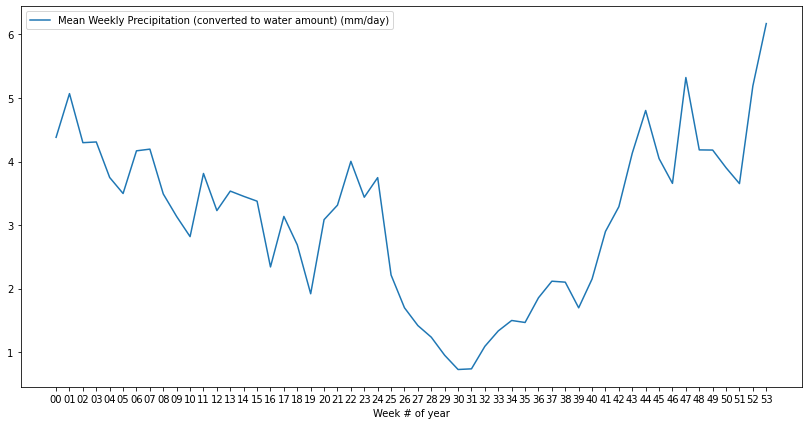

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 7))

# plot out our time series - have 00 and 53 as weeks is normal due to how python handles week numbers internally.
ax.plot(gb, color='tab:blue', label='Mean Weekly Precipitation (converted to water amount) (mm/day)')

ax.set_xlabel('Week # of year')
ax.legend(loc='upper left')
plt.show()

# Creating an Aggregated Output Raster

Now that we've inspected our data and it looks reasonable, we will go ahead and make a raster of average summer precipitation, an important factor for wildfire management and habitat suitability for numerous species.



PROJCS["unnamed",GEOGCS["unknown",DATUM["unknown",SPHEROID["Spheroid",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",25],PARAMETER["standard_parallel_2",60],PARAMETER["latitude_of_origin",42.5],PARAMETER["central_meridian",-100],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["kilometre",1000,AUTHORITY["EPSG","9036"]]]


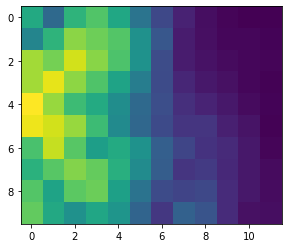

In [41]:
from osgeo import gdal,osr
import matplotlib.pyplot as plt
from glob import glob
import numpy as np

# output file name
out_geotiff = "data/mean_summer_precipitation.tif"

## for each file, get the data for the 152nd-244th days of the year (june thru august), 
## and add each pixel's value to get the cumulative precip for each pixel,
## for that date window. We also get the number of rows/columns here since it's uniform across all files.
arrays = []
for file in glob("data/daymet/daymet_prcp*.nc"):
    ds = gdal.Open('NETCDF:{}:prcp'.format(file))
    ncols = ds.RasterXSize
    nrows = ds.RasterYSize
    arr = np.sum(ds.ReadAsArray()[152:244,:,:], axis=0)
    arrays.append(arr)

# add all of the years together into a YearsXrowsXcols array
stack = np.stack(arrays, axis = 0)

# take the average cumulative precip across 0th axis, aka years
out_arr = stack.mean(axis=0)
# Plot the output dataset in rawspace just to see how it looks
plt.imshow(out_arr)

# Create output
driver = gdal.GetDriverByName("GTiff")
raster = driver.Create(out_geotiff,ncols,nrows,1,gdal.GDT_Float32)

# Add geo information to output
raster.SetGeoTransform(ds.GetGeoTransform()) 
raster.SetProjection(ds.GetProjectionRef())
print(ds.GetProjection())

# Write data and set nodata
raster.GetRasterBand(1).WriteArray(out_arr)
raster.GetRasterBand(1).SetNoDataValue(-9999)
raster.FlushCache()
del raster


# Resampling 

Now that we have the variable we are interested in in a nice format, we often want to resample a dataset to match the spatial resolution of another dataset. Here we will use the `gdalwarp` utility in Python to smooth this raster down to 30 meters and crop it to our study area boundary. This final product will then be suitable for Species Distribution Modeling, ecological forecasts, and other applications.

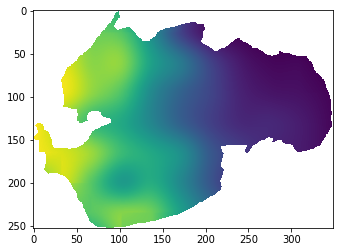

In [78]:
### Let's put our aoi into UTM zone 11 so we can use linear units to clip our raster
aoi = aoi.to_crs(epsg=26911)
aoi.to_file("data/aoi/aoi_26912.shp")

### first we need to project our dataset, then resample it to a desired resolution (30m in this case)
### then we will clip it with our AOI as the "cutline"
projected_gtiff = "data/mean_summer_precipitation_26911.tif"
resampled_gtiff = "data/mean_summer_precipitation_26911_resampled.tif"
clipped_gtiff = "data/mean_summer_precipitation_26911_resampled_clipped.tif"

### Use gdal warp to reproject into utm zone 11
gdal.Warp(projected_gtiff, out_geotiff, dstSRS = "epsg:26911")
### resample to 30m with cubic convolution
gdal.Warp(resampled_gtiff, projected_gtiff, xRes = 30, yRes = 30, resampleAlg="cubic")
### crop to study area
gdal.Warp(clipped_gtiff, resampled_gtiff, cropToCutline=True, cutlineDSName="data/aoi/aoi_26912.shp")

### plot the output in rawspace to examine the new smooth raster!
data = gdal.Open(clipped_gtiff)
arr = data.ReadAsArray()
arr = np.ma.masked_where(arr == -9999, arr)
plt.imshow(arr)

### clean up intermediaries
!rm data/mean_summer_precipitation_26911_resampled.tif
!rm data/mean_summer_precipitation_26911_resampled_clipped.tif
